# CFL and upwind

Let's start with the linear 1D advection equation

$$
\partial_t u + c \partial_x u = 0
$$

with periodic conditions on $[0,1)$. For any periodic differentiable function $\phi$, a solution is 

$$
u(x,t) = \phi(x-ct), 
$$

which represents transport at velocity $c$. If an initial condition is supplied, then $\phi(x)=u_0(x)$. 

## Upwind

A natural semidiscretization is to use a uniform grid in space and centered differences for $\partial_x$, and this works fine. But we will start with 1st-order forward and backward differences for $\partial_x$ in order to illustrate an important principle. Specifically, we pose the problem in the method of lines as 

$$
\partial_t \mathbf{u} = -c\mathbf{A} \mathbf{u}
$$

where $\mathbf{A}$ is either type of differentiation matrix, and look at the relevant eigenvalues for absolute stability.

In [1]:
using LinearAlgebra

# forward difference:
Dxf = n -> n*diagm(0=>-ones(n),1=>ones(n-1),1-n=>[1.])
Dxf(5)

5×5 Matrix{Float64}:
 -5.0   5.0   0.0   0.0   0.0
  0.0  -5.0   5.0   0.0   0.0
  0.0   0.0  -5.0   5.0   0.0
  0.0   0.0   0.0  -5.0   5.0
  5.0   0.0   0.0   0.0  -5.0

In [2]:
# backward difference:
Dxb = n -> n*diagm(0=>ones(n),-1=>-ones(n-1),n-1=>[-1.])
Dxb(5)

5×5 Matrix{Float64}:
  5.0   0.0   0.0   0.0  -5.0
 -5.0   5.0   0.0   0.0   0.0
  0.0  -5.0   5.0   0.0   0.0
  0.0   0.0  -5.0   5.0   0.0
  0.0   0.0   0.0  -5.0   5.0

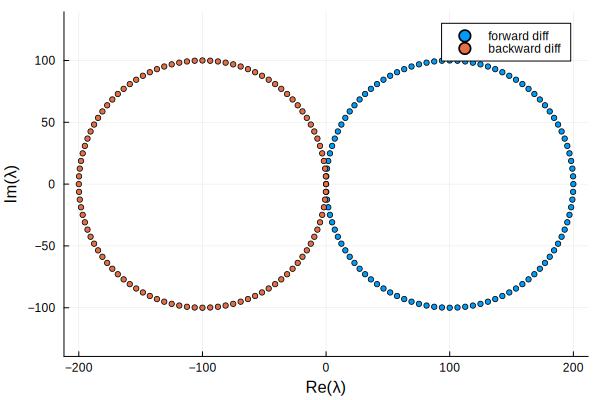

In [3]:
c = 1
using Plots
scatter(eigvals(-c*Dxf(100)),m=3,label="forward diff",
    aspect_ratio=1)
scatter!(eigvals(-c*Dxb(100)),m=3,label="backward diff",
    xlabel="Re(λ)",ylabel="Im(λ)")

We can easily predict and show that the eigenvalues lie on a circle of radius $n$ centered at either $\pm n$. The point is that only the backward difference case allows the possibility of lying within most stability regions after scaling by the time step. (While you might find specific instances of stable integrations for particular integrators and step sizes with forward differences, instability will manifest as $\tau\to 0$ because the boundary of the region has to be tangent to the imaginary axis at the origin.)

There's a simple intuitive interpretation. For $c=1$ as in the picture above, the transport in the PDE is from left to right. Sitting at one node, the proper way to forecast the future is to look in the *upwind* direction, which is to the left. The future solution does not depend at all on what lies to the right, and building your finite difference looking only in that direction cannot lead to convergence. 

For $c<0$, the roles of forward and backward differences would be reversed: the upwind direction requires the forward difference. What about centered differences, you ask?

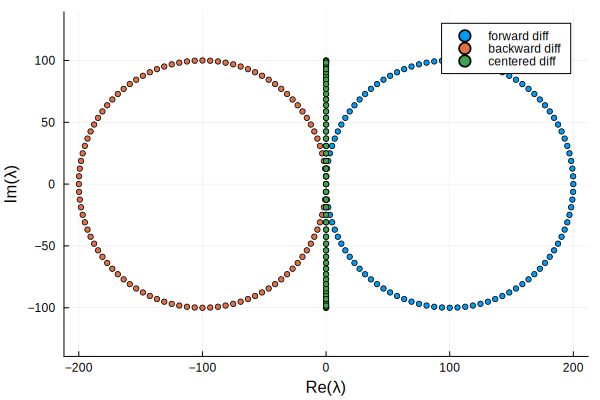

In [4]:
Dxc = n -> n/2*diagm(1-n=>[1.],-1=>-ones(n),1=>ones(n-1),n-1=>[-1.])
scatter!(eigvals(-c*Dxc(100)),m=3,label="centered diff",
    xlabel="Re(λ)",ylabel="Im(λ)")

As the upwinding argument suggests, a centered difference is useful regardless of the sign of $c$. Also note that the picture suggests (not proves) that these operators are much less stiff than diffusion is. In fact, the eigenvalues do scale as $O(1/h)$, and a method with a bounded stability region would have a restriction $\tau = O(h)$, which is considered mild.

Why not always use centered differences, then? There are a couple of reasons. One is that there are more IVP integrators that include a region around the negative real axis than ones that include a part of the imaginary axis. The more important reason is that in practice we are often interested in problems with steep gradients or *shocks*, and differencing across that gradient is detrimental to accuracy (or potentially just wrong, for actual shocks).

## The CFL condition

There is a more general and rigorous framework for the observations about upwinding.

::::{prf:definition} Domain of dependence
Let $u(x,t)$ be the solution of an evolutionary PDE with initial condition $u_0(x)$. The  **domain of dependence** of the solution at $(x,t)$ is the set of all $x$ such that $u_0(x)$ can possibly affect $u(x,t)$. If this domain of dependence lies entirely in one direction relative to $x$, then that direction is called the **upwind** direction of the PDE, and its opposite is the **downwind** direction.
::::

In the advection equation, the domain of dependence at $(x,t)$ is the single point $\{x-ct\}$, and the upwind direction is to the left or to the right of $x$ if $c$ is positive or negative, respectively.

::::{prf:definition} Numerical domain of dependence
Let $U_{i,j}$ be the approximate solution of an evolutionary PDE at $x=x_i$, $t=t_j$ from a numerical method, when the initial condition is given by $U_{i,0}$ for all $i$. The **numerical domain of dependence** of the method at $(x_i,t_j)$ is the set of all $x_i$ such that $U_{i,0}$ can possibly affect $U_{i,j}$.
::::

::::{prf:example}
Suppose we discretize by a centered difference in space and Euler in time. The numerical solution $U_{i,j}$ at $x=x_i$, $t=t_j$ can depend directly only on $U_{i-1,j}$, $U_{i,j}$, and $U_{i+1,j}$. Going back another time step, the dependence extends to space positions $i-2$ and $i+2$, and so on. When we reach the initial time, the dependence of $U_{i,j}$ reaches from $x_{i-j}$ to $x_{i+j}$, or between $x_i-jh$ and $x_i+jh$. Once $2jh$ is equal to the length of the domain interval, the entire spatial grid is in the numerical DoD. 

For any particular discretization this set is discrete, but if the step sizes are taken to zero in a fixed ratio, the numerical DoD fills in the region between the extremes. Ignoring boundaries, the situation is illustrated in {numref}`figure-cflpicture`.
::::

```{figure} cflpicture.svg
:name: figure-cflpicture
:width: 450px
Numerical domain of dependence for the centered + Euler scheme. If $\tau$ and $h$ are infinitesimally small, the shaded region is filled in.
```

Here is a celebrated theorem that also provides a handy rule of thumb.

::::{prf:theorem} Courant–Friedrichs–Lewy (CFL) condition
In order for a numerical method for an advection equation to converge to the correct solution, the limiting numerical domain of dependence must contain the exact domain of dependence.
::::

The CFL condition is about both the shape of the domain of dependence (i.e., upwinding) and its size. 

::::{prf:example}
Returning to the previous example, the numerical domain of dependence depicted in {numref}`Figure {number} <figure-cflpicture>` contains the exact domain of dependence $\{x_i-c t_j\}$ only if $x_i-j h \le x_i -c t_j \le x_i+jh$, or $|c j\tau|\le j h$. That is,

:::{math}
  \frac{h}{\tau} \ge |c|, \quad  \tau,h\rightarrow 0.
:::

We can view this condition as a restriction on the time step: $\tau \le h/|c|$. 
::::

:::{caution} 
The CFL condition is a *necessary* criterion for convergence, but not a *sufficient* one. For instance, we could define $U_{i,j}$ to be the average value of the initial condition for all $j>0$. While that would make the numerical domain of dependence equal to the entire domain, this method has nothing to do with solving a PDE correctly!

In the example above, no value of $\tau$ can scale the eigenvalues to lie within the stability region of Euler, so the CFL conclusion fails to be sharp.
:::

Note that an implicit IVP integrator leads to automatic satisfaction of the CFL condition, because one time step induces (possible) dependence on all the previous values. 

One way to interpret the restriction from the above example scales nicely to other problems as a rule of thumb: *the numerical method must allow propagation at at least the maximum speed possible in the solution*. For instance, if you want to simulate weather using an explicit method on a grid with cell size 1 km while tracking wind speeds up to 200 km/hr, then you will need a time step no larger than 1/200 hr in order to even have a chance at stability.